In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, DefineVariable
import scipy.sparse as sp
import scipy.sparse.linalg as spln
import metropolishastings as mh

We use the Metropolis-Hastings algorithm to perform Bayesian estimation of the unkown parameters of a logit model. 


# Definition of the choice model and the log likelihood

Load and clean the data

In [2]:
df = pd.read_csv('swissmetro.dat', sep='\t')
database = db.Database("swissmetro",df)
globals().update(database.variables)
exclude = (( PURPOSE != 1 ) * (  PURPOSE   !=  3  ) +  ( CHOICE == 0 )) > 0
database.remove(exclude)


Parameters to be estimated

In [3]:
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
ASC_SM = Beta('ASC_SM', 0, None, None, 1)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

Definition of new variables

In [4]:
SM_COST = SM_CO * (GA == 0)
TRAIN_COST = TRAIN_CO * (GA == 0)

# Definition of new variables: adding columns to the database
CAR_AV_SP = DefineVariable('CAR_AV_SP', CAR_AV * (SP != 0), database)
TRAIN_AV_SP = DefineVariable('TRAIN_AV_SP', TRAIN_AV * (SP != 0), database)
TRAIN_TT_SCALED = DefineVariable('TRAIN_TT_SCALED', TRAIN_TT / 100.0, database)
TRAIN_COST_SCALED = DefineVariable(
    'TRAIN_COST_SCALED', TRAIN_COST / 100, database
)
SM_TT_SCALED = DefineVariable('SM_TT_SCALED', SM_TT / 100.0, database)
SM_COST_SCALED = DefineVariable('SM_COST_SCALED', SM_COST / 100, database)
CAR_TT_SCALED = DefineVariable('CAR_TT_SCALED', CAR_TT / 100, database)
CAR_CO_SCALED = DefineVariable('CAR_CO_SCALED', CAR_CO / 100, database)


Definition of the utility functions

In [5]:
V1 = ASC_TRAIN + B_TIME * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED
V2 = ASC_SM + B_TIME * SM_TT_SCALED + B_COST * SM_COST_SCALED
V3 = ASC_CAR + B_TIME * CAR_TT_SCALED + B_COST * CAR_CO_SCALED

Associate utility functions with the numbering of alternatives

In [6]:
V = {1: V1, 2: V2, 3: V3}

Associate the availability conditions with the alternatives

In [7]:
av = {1: TRAIN_AV_SP, 2: SM_AV, 3: CAR_AV_SP}

Definition of the model. This is the contribution of each
observation to the log likelihood function.

In [8]:
logprob = models.loglogit(V, av, CHOICE)

Create the Biogeme object

In [9]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = '01logit'
biogeme.generateHtml = False
biogeme.generatePickle = False

# Estimation with maximum likelihood

We first estimate thre parameters with maximum likelihood, to have a reference.

In [10]:
results = biogeme.estimate()

In [11]:
results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.154633,0.043235,-3.576524,0.000348,0.058163,-2.658590,0.007847
ASC_TRAIN,-0.701187,0.054874,-12.778150,0.000000,0.082562,-8.492857,0.000000
B_COST,-1.083790,0.051830,-20.910405,0.000000,0.068225,-15.885521,0.000000
B_TIME,-1.277859,0.056883,-22.464561,0.000000,0.104254,-12.257120,0.000000


# Estimation with the Metropolis-Hastings algorithm

First, we define a function that calculates the log of the pdf of a Normal distribution $N(\mu, \Sigma)$ of dimension $k$:
$$ f(x) = -\frac{1}{2}\left(k \ln(2\pi) + \ln \text{det}(\Sigma) + (x-\mu)^T \Sigma^{-1}(x-\mu) \right).$$

In [12]:
def lognormpdf(x, mu=None, S=None):
    """Calculate gaussian probability density of x, when x ~ N(mu,sigma)"""
    nx = x.size
    if mu is None:
        mu = np.array([0] * nx)
    if S is None:
        S = np.identity(nx)

    if sp.issparse(S):
        lu = spln.splu(S)
        diagL = lu.L.diagonal()
        diagU = lu.U.diagonal()
        logdet = np.log(diagL).sum() + np.log(diagU).sum()
    else:
        logdet = np.linalg.slogdet(S)[1] 
    norm_coeff = nx * np.log(2 * np.pi) + logdet

    err = x - mu
    if sp.issparse(S):
        numerator = spln.spsolve(S, err).T.dot(err)
    else:
        numerator = np.linalg.solve(S, err).T.dot(err)

    return -0.5 * (norm_coeff + numerator)


Here, the state is a vector with the values of the parameters.

The generating Markov process is a random walk, with a fixed step.
Note that the jumps are symmetric, so that the transition probabilities are irrelevant here. We put one by default, and the log of one is zero.

In [13]:
step_random_walk = 0.1
def myprocess(state):
    ksi = np.random.normal(size=len(state))
    next_state = state + step_random_walk * ksi
    return next_state, 0, 0

The weights are the numerator of the posterior probability, which is the product of the likelihood and the prior. We assume here that the prior is a vector of independent normally distributed parameters, with mean 0, and variance 100. 

In [14]:
variance = 1000
def logweight(state):
    logprior = lognormpdf(
        state, 
        mu=None, 
        S=sp.diags([variance]*state.size, format = 'csc')
    )
    loglike = biogeme.calculateLikelihood(x=state, scaled=False)
    return logprior + loglike

The indicators are the parameters of interest, generated by each draw. In this case, the indicators are the states themselves.

In [15]:
def indicators(one_draw):
    return one_draw

We start four independent Markov processes, each starting from a different state.

In [16]:
initialStates = [
    np.array([0, 0, 0, 0]),
    np.array([-1, -1, -1, -1]),
    np.array([1, 1, -1, -1]),
    np.array([0, 0, -1, -1]),
]
numberOfDraws = 10000
maxNumberOfIterations = 10

We apply the MH algorithm.

In [17]:
draws, estimates, convergence, numberOfTrials = mh.MetropolisHastings(
    initialStates,
    myprocess,
    logweight,
    indicators,
    numberOfDraws,
    maxNumberOfIterations,
)

Warmup


100%|██████████| 10000/10000 [03:22<00:00, 49.43it/s]


Trial 0 with 10000 draws
Generated draws: (4, 10000, 4)
Potential scale reduction: [1.00507805 1.00537913 1.00213003 1.00393784]
    should be at most 1.1
Effective number of simulation draws: [ 870.98234506  725.808093   1114.19450814  722.1829378 ]
    should be at least 40


Here are the estimated parameters

In [18]:
estimates

array([-0.15705397, -0.70232574, -1.08389159, -1.27674434])

We can compare them with the estimates from maximum likelihood 

In [19]:
results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.154633,0.043235,-3.576524,0.000348,0.058163,-2.658590,0.007847
ASC_TRAIN,-0.701187,0.054874,-12.778150,0.000000,0.082562,-8.492857,0.000000
B_COST,-1.083790,0.051830,-20.910405,0.000000,0.068225,-15.885521,0.000000
B_TIME,-1.277859,0.056883,-22.464561,0.000000,0.104254,-12.257120,0.000000


We also calculate the empirical standard deviations, that can be also compared with the maximum likelihood estimates.

In [20]:
for d in draws:
    print(np.std(d))

0.04318326698007471
0.054266658196275526
0.051304189354195937
0.056184373651093494


Finally, we plot the distribution of the generated draws, for each of the four parameters.

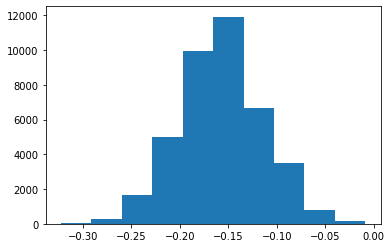

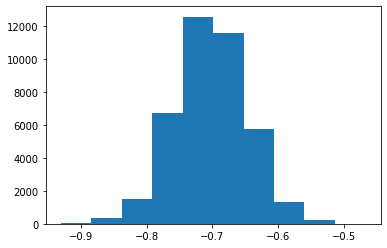

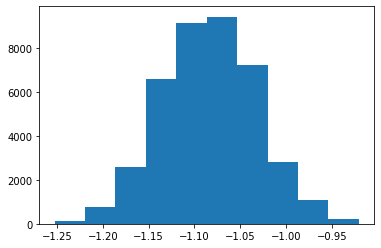

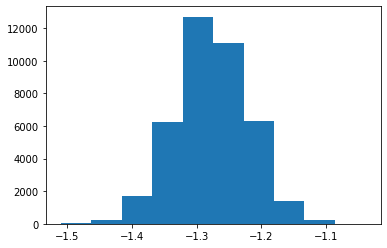

In [21]:
for d in draws:
    plt.hist(d)
    plt.show()